In [145]:
import pandas as pd
import numpy as np
import datetime as dt
#from scipy import linalg
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm import tqdm  #### loop 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import RFE
from sklearn.feature_selection import RFECV
import statsmodels.api as sm
import math
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score


import warnings
warnings.filterwarnings('ignore')

# Use original feature set 

In [2]:
train = pd.read_csv('application_train.csv')

In [3]:
#transform string features into categorical
for y in train.columns:
    if(train[y].dtype != np.float64 and train[y].dtype != np.int64):
        df = pd.get_dummies(train[[y]])
        train = train.drop(y,axis = 1)
        train = train.join(df)
print(len(train))

307511


In [4]:
train = train.dropna(axis = 0)
print(len(train))

11351


In [5]:
xdata = train.drop(columns=['TARGET'])
ydata = train[['TARGET']]
xtrain, xtest, ytrain, ytest = train_test_split(xdata,ydata,test_size=0.3)

In [6]:
lr = LogisticRegression()  
lr.fit(xtrain,ytrain)
train_score = lr.score(xtrain,ytrain)
test_score = lr.score(xtest,ytest)
print(train_score, test_score)

0.9379483952171177 0.9436288901937757


In [7]:
y_pred = np.where(lr.predict_proba(xtest)[:,1] > 0.5, 1, 0)
y_true = ytest
    
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print('tn, fp, fn, tp: ', tn, fp, fn, tp)
Precision = tp / (tp + fp)
print('precision = ', Precision)
Recall = tp / (tp + fn)
print('recall = ', Recall)
f1 = f1_score(y_true, y_pred)
print('f1 score = ', f1)


tn, fp, fn, tp:  3214 0 192 0
precision =  nan
recall =  0.0
f1 score =  0.0


In [8]:
#calculate roc and auc
ytrue = ytest.to_numpy().astype(int)
yscore = lr.decision_function(xtest)
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(ytrue, yscore)
roc_auc = auc(fpr, tpr)

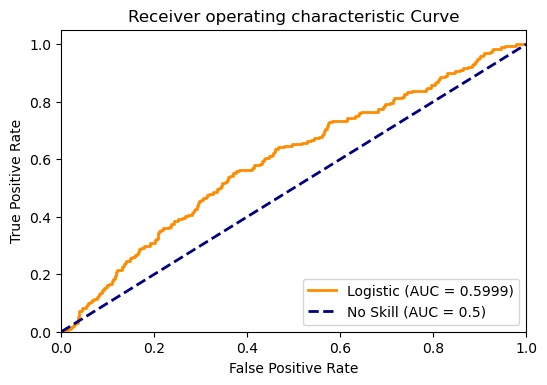

In [9]:
#plot roc curve
plt.figure(figsize=(6,4),dpi=100)
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="Logistic (AUC = %0.4f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--",label="No Skill (AUC = 0.5)" )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic Curve")
plt.legend(loc="lower right")
plt.show()

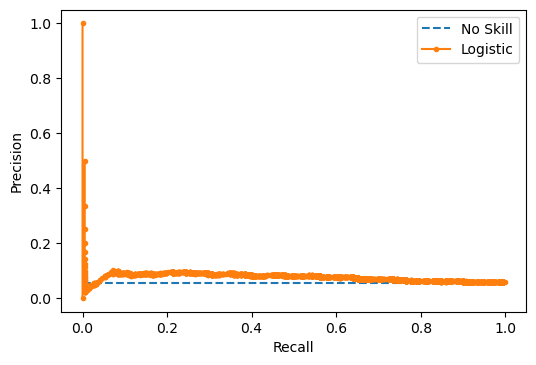

In [10]:
#precision-recall curve
probs = lr.predict_proba(xtest)
probs = probs[:, 1]

precision, recall, thresholds = precision_recall_curve(ytest, probs)
no_skill = len(ytest[ytest['TARGET']==1]) / len(ytest)

plt.figure(figsize=(6,4),dpi=100)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

# With feature engineering

In [20]:
df = pd.read_csv('final_train.csv')
df.head()

,Unnamed: 0,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,...,CNT_DRAWINGS_OTHER_CURRENT_tol,CNT_DRAWINGS_POS_CURRENT_tol,CNT_INSTALMENT_MATURE_avg,CNT_INSTALMENT_MATURE_tol,CNT_INSTALMENT_MATURE_0_1_year,CNT_INSTALMENT_MATURE_1_2_year,SK_DPD_avg,SK_DPD_max,SK_DPD_DEF_avg,SK_DPD_DEF_max
0,0,100002,1,Cash loans,M,N,Y,0,202500.0,406597.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,100003,0,Cash loans,F,N,N,0,270000.0,1293502.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,100004,0,Revolving loans,M,Y,Y,0,67500.0,135000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,100006,0,Cash loans,F,N,Y,0,135000.0,312682.5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,100007,0,Cash loans,M,N,Y,0,121500.0,513000.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [21]:
for y in df.columns:
    if(df[y].dtype != np.float64 and df[y].dtype != np.int64):
        temp = pd.get_dummies(df[[y]])
        df = df.drop(y,axis = 1)
        df = df.join(temp)
print(len(df))

307511


In [22]:
df1 = df[df['TARGET']==1]
df2 = df[df['TARGET']==0]
df2 = df2.sample(frac = 0.1, replace = False)
df = pd.concat([df1,df2])

In [14]:
#equal weight binning
def pct_rank_qcut(series, n):
    edges = pd.Series([float(i) / n for i in range(n + 1)])
    f = lambda x: (edges >= x).argmax()
    return series.rank(pct=1).apply(f)

def equal_weight_bin(df, y):
    if (df[y].nunique() == 2):
        return df[y]
    elif y != 'Unnamed: 0' and y != 'SK_ID_CURR' and y !='TARGET':
        return pct_rank_qcut(df[y], 5)

In [15]:
df2 = df
for y in df2.columns:
    print(y)
    if y != 'Unnamed: 0' and y != 'SK_ID_CURR' and y !='TARGET':
        if (df2[y].nunique() == 2):      
            df2[y+'_grp'] = df2[y]
        else:
            df2[y+'_grp'] = pct_rank_qcut(df2[y], 5)

        sdata = df2[[y+'_grp','TARGET']]
        sdata1 = sdata.groupby(y+'_grp').sum()
        sdata1['total'] = 1
        sdata1['default'] = sdata1['TARGET']/sdata1['TARGET'].sum()
        sdata1['non-default'] = (sdata1['total'] - sdata1['TARGET'])/(sdata1['total'] - sdata1['TARGET']).sum()
        sdata1['woe'] = np.log(sdata1['non-default']/sdata1['default'])
        sdata1 = sdata1.reset_index().rename(columns={'index': y+'_grp'})
        #print(sdata1)
        #print(sdata[y+'_grp'])
        df2[y+'_woe'] = 0
        for i in range(len(df2[y+'_grp'])):
            for j in range(len(sdata1)):
                if df2[y+'_grp'].iloc[i] == sdata1[y+'_grp'].iloc[j]: 
                   # print(j)
                  #  print(df[y+'_grp'].iloc[i])
                  #  print(sdata1['woe'].iloc[j])
                    df2[y+'_woe'].iloc[i] = sdata1['woe'].iloc[j]
        #print(df[[y+'_grp',y+'_woe']])

Unnamed: 0
SK_ID_CURR
TARGET
CNT_CHILDREN
AMT_INCOME_TOTAL
AMT_CREDIT
AMT_ANNUITY
AMT_GOODS_PRICE
REGION_POPULATION_RELATIVE
DAYS_BIRTH
DAYS_EMPLOYED
DAYS_REGISTRATION
DAYS_ID_PUBLISH
FLAG_MOBIL
FLAG_EMP_PHONE
FLAG_WORK_PHONE
FLAG_CONT_MOBILE
FLAG_PHONE
FLAG_EMAIL
CNT_FAM_MEMBERS
REGION_RATING_CLIENT
REGION_RATING_CLIENT_W_CITY
HOUR_APPR_PROCESS_START
REG_REGION_NOT_LIVE_REGION
REG_REGION_NOT_WORK_REGION
LIVE_REGION_NOT_WORK_REGION
REG_CITY_NOT_LIVE_CITY
REG_CITY_NOT_WORK_CITY
LIVE_CITY_NOT_WORK_CITY
EXT_SOURCE_2
EXT_SOURCE_3
YEARS_BEGINEXPLUATATION_AVG
FLOORSMAX_AVG
YEARS_BEGINEXPLUATATION_MODE
FLOORSMAX_MODE
YEARS_BEGINEXPLUATATION_MEDI
FLOORSMAX_MEDI
TOTALAREA_MODE
OBS_30_CNT_SOCIAL_CIRCLE
DEF_30_CNT_SOCIAL_CIRCLE
OBS_60_CNT_SOCIAL_CIRCLE
DEF_60_CNT_SOCIAL_CIRCLE
DAYS_LAST_PHONE_CHANGE
FLAG_DOCUMENT_2
FLAG_DOCUMENT_3
FLAG_DOCUMENT_4
FLAG_DOCUMENT_5
FLAG_DOCUMENT_6
FLAG_DOCUMENT_7
FLAG_DOCUMENT_8
FLAG_DOCUMENT_9
FLAG_DOCUMENT_10
FLAG_DOCUMENT_11
FLAG_DOCUMENT_12
FLAG_DOCUMENT_13
FLAG

In [16]:
df2.to_csv('final_train_woe_down.csv')

In [17]:
df_woe = pd.read_csv('final_train_woe_down.csv')
df_woe.head()

,Unnamed: 0,Unnamed: 0.1,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Transport: type 4_grp,ORGANIZATION_TYPE_Transport: type 4_woe,ORGANIZATION_TYPE_University_grp,ORGANIZATION_TYPE_University_woe,ORGANIZATION_TYPE_XNA_grp,ORGANIZATION_TYPE_XNA_woe,EMERGENCYSTATE_MODE_No_grp,EMERGENCYSTATE_MODE_No_woe,EMERGENCYSTATE_MODE_Yes_grp,EMERGENCYSTATE_MODE_Yes_woe
0,0,0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0.000039,0,0.00004,0,0.000035,1,-0.000009,0,0.000040
1,26,26,100031,1,0,112500.0,979992.0,27076.5,702000.0,0.018029,...,0,0.000039,0,0.00004,0,0.000035,0,0.000008,1,-0.004414
2,40,40,100047,1,0,202500.0,1193580.0,35028.0,855000.0,0.025164,...,0,0.000039,0,0.00004,0,0.000035,1,-0.000009,0,0.000040
3,42,42,100049,1,0,135000.0,288873.0,16258.5,238500.0,0.007305,...,0,0.000039,0,0.00004,0,0.000035,0,0.000008,0,0.000040
4,81,81,100096,1,0,81000.0,252000.0,14593.5,252000.0,0.028663,...,0,0.000039,0,0.00004,1,-0.000254,0,0.000008,0,0.000040


In [23]:
#woe
def iv_cal(data,feature):
    sdata = data[[feature,'TARGET']]
    sdata.dropna(inplace=True)
    sdata['total'] = 1
    sdata['group'] = equal_weight_bin(data, feature)
    sdata1 = sdata.groupby('group').sum()
    sdata1['default'] = sdata1['TARGET']/sdata1['TARGET'].sum()
    sdata1['non-default'] = (sdata1['total'] - sdata1['TARGET'])/(sdata1['total'] - sdata1['TARGET']).sum()
    sdata1['woe'] = np.log(sdata1['non-default']/sdata1['default'])
    sdata1['iv'] = (sdata1['non-default'] - sdata1['default'])*sdata1['woe']
    return sdata1['iv'].sum()

signidf = pd.Series(index=df.columns)

for y in df.columns:
    if y != 'Unnamed: 0' and y != 'SK_ID_CURR' and y !='TARGET' and y !='TARGET_grp':
        signidf.loc[y] = iv_cal(df,y)
signidf

Unnamed: 0                                  NaN
SK_ID_CURR                                  NaN
TARGET                                      NaN
CNT_CHILDREN                           0.005984
AMT_INCOME_TOTAL                       0.010370
                                         ...   
ORGANIZATION_TYPE_Transport: type 4    0.000500
ORGANIZATION_TYPE_University           0.001155
ORGANIZATION_TYPE_XNA                  0.031978
EMERGENCYSTATE_MODE_No                 0.028661
EMERGENCYSTATE_MODE_Yes                0.000555
Length: 263, dtype: float64

In [24]:
features = signidf[signidf>0.02].index.tolist()
col = [y+'_woe' for y in features]

data = df_woe[col].dropna() 
#data = df_woe[col].fillna(df_woe[col].median())

data

,AMT_CREDIT_woe,AMT_GOODS_PRICE_woe,REGION_POPULATION_RELATIVE_woe,DAYS_BIRTH_woe,DAYS_EMPLOYED_woe,DAYS_REGISTRATION_woe,DAYS_ID_PUBLISH_woe,FLAG_EMP_PHONE_woe,REGION_RATING_CLIENT_woe,REGION_RATING_CLIENT_W_CITY_woe,...,NAME_INCOME_TYPE_Maternity leave_woe,NAME_INCOME_TYPE_Pensioner_woe,NAME_INCOME_TYPE_Student_woe,NAME_INCOME_TYPE_Unemployed_woe,NAME_INCOME_TYPE_Working_woe,NAME_EDUCATION_TYPE_Higher education_woe,NAME_EDUCATION_TYPE_Secondary / secondary special_woe,OCCUPATION_TYPE_Laborers_woe,ORGANIZATION_TYPE_XNA_woe,EMERGENCYSTATE_MODE_No_woe
0,0.000014,0.000013,0.000021,0.000034,3.410814e-05,0.000009,0.000013,0.000035,0.000065,0.000066,...,0.00004,0.000035,0.00004,0.00004,0.000015,0.000033,0.000029,-0.000091,0.000035,-0.000009
1,-0.000039,0.000032,0.000021,-0.000016,-2.437392e-07,-0.000007,0.000013,0.000035,-0.000066,0.000066,...,0.00004,0.000035,0.00004,0.00004,0.000015,0.000033,0.000029,0.000028,0.000035,0.000008
2,-0.000039,-0.000004,-0.000005,-0.000016,2.341502e-05,0.000016,0.000023,0.000035,0.000065,0.000066,...,0.00004,0.000035,0.00004,0.00004,-0.000024,0.000033,0.000029,-0.000091,0.000035,-0.000009
3,0.000014,0.000013,0.000013,0.000019,-5.448795e-05,0.000016,-0.000041,0.000035,-0.000066,-0.000079,...,0.00004,0.000035,0.00004,0.00004,0.000015,0.000033,0.000029,0.000028,0.000035,0.000008
4,-0.000011,0.000013,-0.000005,-0.000060,-2.779621e-05,-0.000007,-0.000011,-0.000254,0.000065,0.000066,...,0.00004,-0.000255,0.00004,0.00004,-0.000024,0.000033,0.000029,0.000028,-0.000254,0.000008
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
53089,-0.000011,0.000067,-0.000005,0.000034,-2.437392e-07,0.000008,0.000005,0.000035,0.000065,0.000066,...,0.00004,0.000035,0.00004,0.00004,0.000015,-0.000169,-0.000108,0.000028,0.000035,0.000008
53090,0.000005,0.000032,-0.000005,-0.000060,-5.448795e-05,-0.000033,-0.000041,0.000035,0.000065,0.000066,...,0.00004,0.000035,0.00004,0.00004,0.000015,0.000033,0.000029,-0.000091,0.000035,-0.000009
53091,0.000021,0.000071,-0.000030,-0.000016,3.410814e-05,-0.000007,0.000013,0.000035,0.000065,0.000066,...,0.00004,0.000035,0.00004,0.00004,0.000015,0.000033,0.000029,0.000028,0.000035,-0.000009
53092,0.000014,0.000067,-0.000005,0.000034,-2.437392e-07,0.000008,0.000023,0.000035,0.000065,0.000066,...,0.00004,0.000035,0.00004,0.00004,0.000015,-0.000169,-0.000108,0.000028,0.000035,-0.000009


# Clustering

In [25]:
### clustering
X = np.asarray(data)
scale = StandardScaler() 
X1 = scale.fit_transform(X).T

100%|███████████████████████████████████████████| 14/14 [00:06<00:00,  2.02it/s]


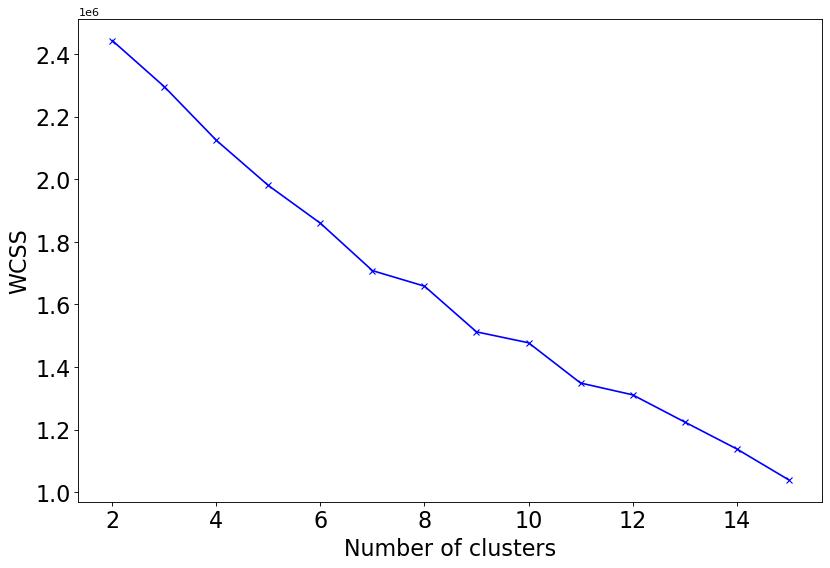

In [26]:
n_clusters = np.arange(2, 16)
### elbow method
cost = []
for i in tqdm(n_clusters):
    kmean = KMeans(i)
    kmean.fit(X1)
    cost.append(kmean.inertia_)  
plt.figure(figsize=(12,8),dpi=80)
plt.plot(n_clusters,cost, 'bx-')
plt.xlabel("Number of clusters",fontsize=20)
plt.ylabel("WCSS",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.show()

100%|███████████████████████████████████████████| 14/14 [00:06<00:00,  2.18it/s]


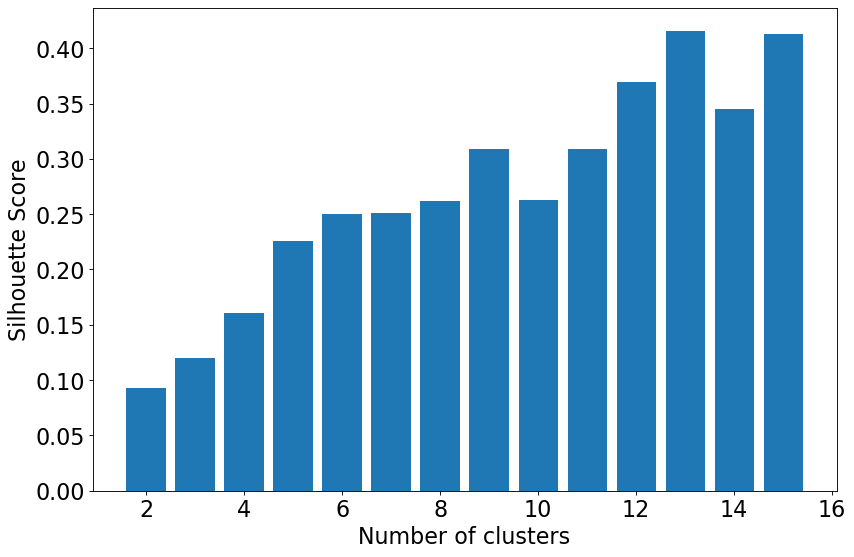

In [27]:
### silhouette_score
sscores = [] 

for n_cluster in tqdm(n_clusters):
    sscores.append(silhouette_score(X1, KMeans(n_cluster).fit_predict(X1))) 

# Plotting a bar graph to compare the results 
plt.figure(figsize=(12,8),dpi=80)
plt.bar(n_clusters, sscores)
#plt.plot(n_clusters,sscores, 'bx-')
plt.xlabel('Number of clusters', fontsize = 20) 
plt.ylabel('Silhouette Score', fontsize = 20) 
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
#plt.title('Silhouette score method for k-means',fontsize=20)
plt.show() 

In [197]:
nCluster = 8

In [198]:
kmean = KMeans(nCluster)
kmean.fit(X1)
labels = kmean.labels_
centers = kmean.cluster_centers_
cdata = pd.DataFrame(labels,index=data.columns,columns=['cluster'])

In [199]:
signidf_ = signidf.loc[features]
signidf_.index = [x+'_woe' for x in signidf_.index]
signidf_.name = 'iv'
cdata1 = pd.concat([cdata,signidf_],axis=1)

In [200]:
### identify the nearest cluster
nearest_c = {}
for i in range(nCluster):
    cluster_dis = ((centers - centers[i,:])**2).sum(axis=1)
    nearest_c[i] = pd.Series(cluster_dis,index=range(nCluster)).sort_values().index[1]

In [201]:
### R_square calculation
for k in tqdm(range(len(cdata1))):
    feature = cdata1.index[k]
    datac = cdata1.loc[feature,'cluster']
    nearc = nearest_c[datac]
    cvlist = cdata1[cdata1['cluster']==datac].index.tolist() 
    nvlist = cdata1[cdata1['cluster']==nearc].index.tolist()
    cvdf = data[cvlist]
    nvdf = data[nvlist]
    
    lr = LinearRegression()
    lr.fit(cvdf.drop(feature,axis=1),cvdf[feature])
    cdata1.loc[feature,'Rc'] = lr.score(cvdf.drop(feature,axis=1),cvdf[feature])
    
    lr_nc = LinearRegression()
    lr_nc.fit(nvdf,cvdf[feature])  
    cdata1.loc[feature,'Rn'] = lr_nc.score(nvdf,cvdf[feature])

100%|███████████████████████████████████████████| 58/58 [00:01<00:00, 54.41it/s]


In [202]:
### 1-R_sqaure ratio
cdata1['ratio'] = (1 - cdata1['Rc'])/ (1 - cdata1['Rn'])  

In [203]:
### final feature list
fvlist = []
for g in range(nCluster):
    gcdata = cdata1[cdata1['cluster']==g]
    indepv = gcdata.sort_values('iv').index[-1]
    fvlist.append(indepv)
    indepv2 = gcdata.sort_values('ratio').index[0]
    fvlist.append(indepv2)
fvlist = list(set(fvlist))

In [204]:
fvlist

['DAYS_ENTRY_avg_woe',
 'REGION_RATING_CLIENT_W_CITY_woe',
 'NAME_INCOME_TYPE_Unemployed_woe',
 'CNT_DRAWINGS_0_1_year_woe',
 'NAME_INCOME_TYPE_Student_woe',
 'NAME_INCOME_TYPE_Maternity leave_woe',
 'CODE_GENDER_M_woe',
 'CODE_GENDER_F_woe',
 'FLAG_DOCUMENT_4_woe',
 'ORGANIZATION_TYPE_XNA_woe',
 'FLAG_DOCUMENT_12_woe',
 'NAME_EDUCATION_TYPE_Higher education_woe',
 'EXT_SOURCE_3_woe',
 'AMT_DRAWINGS_ATM_CURRENT_avg_woe',
 'AMT_RECIVABLE_avg_woe',
 'FLOORSMAX_MEDI_woe']

In [146]:
df_woe = pd.read_csv('/Users/lasure/Desktop/final_train_woe_down.csv')


In [147]:
df_woe.head()

,Unnamed: 0,Unnamed: 0.1,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,...,ORGANIZATION_TYPE_Transport: type 4_grp,ORGANIZATION_TYPE_Transport: type 4_woe,ORGANIZATION_TYPE_University_grp,ORGANIZATION_TYPE_University_woe,ORGANIZATION_TYPE_XNA_grp,ORGANIZATION_TYPE_XNA_woe,EMERGENCYSTATE_MODE_No_grp,EMERGENCYSTATE_MODE_No_woe,EMERGENCYSTATE_MODE_Yes_grp,EMERGENCYSTATE_MODE_Yes_woe
0,0,0,100002,1,0,202500.0,406597.5,24700.5,351000.0,0.018801,...,0,0.000039,0,0.00004,0,0.000035,1,-0.000009,0,0.000040
1,26,26,100031,1,0,112500.0,979992.0,27076.5,702000.0,0.018029,...,0,0.000039,0,0.00004,0,0.000035,0,0.000008,1,-0.004414
2,40,40,100047,1,0,202500.0,1193580.0,35028.0,855000.0,0.025164,...,0,0.000039,0,0.00004,0,0.000035,1,-0.000009,0,0.000040
3,42,42,100049,1,0,135000.0,288873.0,16258.5,238500.0,0.007305,...,0,0.000039,0,0.00004,0,0.000035,0,0.000008,0,0.000040
4,81,81,100096,1,0,81000.0,252000.0,14593.5,252000.0,0.028663,...,0,0.000039,0,0.00004,1,-0.000254,0,0.000008,0,0.000040


In [49]:
fvlist=[#'DAYS_ENTRY_avg_woe',
 'REGION_RATING_CLIENT_W_CITY_woe',
 #'NAME_INCOME_TYPE_Unemployed_woe',
 'CNT_DRAWINGS_0_1_year_woe',
 
 #'CODE_GENDER_M_woe',
 'CODE_GENDER_F_woe',

 'ORGANIZATION_TYPE_XNA_woe',

 'NAME_EDUCATION_TYPE_Higher education_woe',
 'EXT_SOURCE_3_woe']
 #'AMT_DRAWINGS_ATM_CURRENT_avg_woe',
 #'AMT_RECIVABLE_avg_woe'
 #'FLOORSMAX_MEDI_woe']

In [72]:
df_woe =df_woe.dropna()
xdata = df_woe[fvlist]
ydata = df_woe[['TARGET']]
xtrain, xtest, ytrain, ytest = train_test_split(xdata,ydata,test_size=0.3,stratify=ydata)

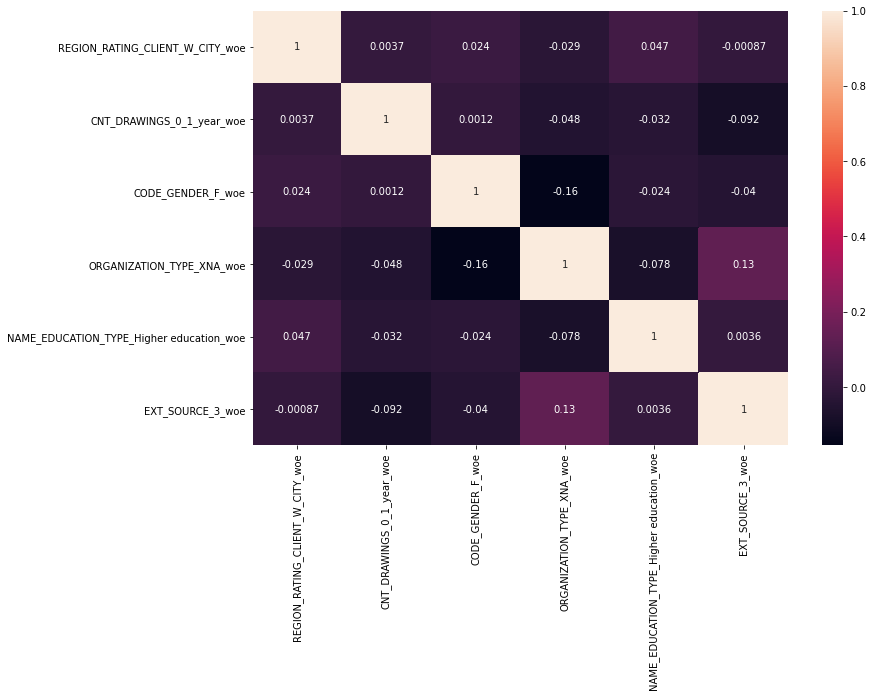

In [73]:
plt.subplots(figsize=(12,8))
sns.heatmap(df_woe[fvlist].corr(), annot=True)
plt.show()

In [86]:
import statsmodels.api as sm
logit_results = sm.GLM(ytrain, xtrain[fvlist], family=sm.families.Binomial()).fit()
print(logit_results.summary())

                 Generalized Linear Model Regression Results                  
Dep. Variable:                 TARGET   No. Observations:                13972
Model:                            GLM   Df Residuals:                    13966
Model Family:                Binomial   Df Model:                            5
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -8696.5
Date:                Tue, 28 Dec 2021   Deviance:                       17393.
Time:                        22:20:50   Pearson chi2:                 1.40e+04
No. Iterations:                     4                                         
Covariance Type:            nonrobust                                         
                                               coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------

In [87]:
xtrain_ = sm.add_constant(xtrain[fvlist])
lr = sm.Logit(ytrain,xtrain_)
fresult = lr.fit()
fresult.summary()

         Current function value: 5.199967
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 TARGET   No. Observations:                13972
Model:                          Logit   Df Residuals:                    13965
Method:                           MLE   Df Model:                            6
Date:                Tue, 28 Dec 2021   Pseudo R-squ.:                  -6.648
Time:                        22:20:51   Log-Likelihood:                -72654.
converged:                      False   LL-Null:                       -9499.4
Covariance Type:            nonrobust   LLR p-value:                     1.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                      -10.0826   2673.874     -0.004      0.997   -5250.779    5230.614
REGION_RATING_CLIENT_W_CITY_woe           1412.4779    149.952      9.420      0.000    1118.578    1706.378
CNT_DRAWINGS_0_1_year_woe                -6474.4345    543.318    -11.916      0.000   -7539.318   -5409.551
CODE_GENDER_F_woe                          1.22e+06   2.68e+08      0.005      0.996   -5.23e+08    5.26e+08
ORGANIZATION_TYPE_XNA_woe                 6114.7329    243.766     25.084      0.000    5636.959    6592.506
NAME_EDUCATION_TYPE_Higher education_woe  7033.4441    317.668     22.141      0.000    6410.827    7656.061
EXT_SOURCE_3_woe                          1.411e+04    342.049     41.251      0.000    1.34e+04    1.48e+04
============================================================================================================

Possibly complete quasi-separation: A fraction 0.18 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""

fvlist.remove('NAME_INCOME_TYPE_Unemployed_woe')
fvlist.remove('DAYS_ENTRY_avg_woe')
fvlist.remove('NAME_INCOME_TYPE_Student_woe')
fvlist.remove('NAME_INCOME_TYPE_Maternity leave_woe')
fvlist.remove('FLAG_DOCUMENT_4_woe')
fvlist.remove('FLAG_DOCUMENT_12_woe')
fvlist.remove('AMT_DRAWINGS_ATM_CURRENT_avg_woe')
fvlist.remove('AMT_RECIVABLE_avg_woe')
fvlist.remove('FLOORSMAX_MEDI_woe')
#fvlist.remove('AMT_RECIVABLE_avg_woe')
#fvlist.remove('FLOORSMAX_MEDI_woe')
#fvlist.remove('NAME_INCOME_TYPE_Student_woe')
#fvlist.remove('amt_balance_avg_woe')
#fvlist.remove('AMT_PAYMENT_TOTAL_CURRENT_tol_woe')
#fvlist.remove('CODE_GENDER_F_woe')


In [75]:
print(fvlist)

['REGION_RATING_CLIENT_W_CITY_woe', 'CNT_DRAWINGS_0_1_year_woe', 'CODE_GENDER_F_woe', 'ORGANIZATION_TYPE_XNA_woe', 'NAME_EDUCATION_TYPE_Higher education_woe', 'EXT_SOURCE_3_woe']


In [76]:
### model fitting

##------------- log result demonstration of sklearn is bad
logisr = LogisticRegression()  
logisr.fit(xtrain[fvlist],ytrain)
train_score = logisr.score(xtrain[fvlist],ytrain)
test_score = logisr.score(xtest[fvlist],ytest)
alpha = logisr.intercept_[0]
coef = logisr.coef_[0]
print(train_score, test_score)

0.5812338963641569 0.5811623246492986


In [139]:
y_pred = np.where(logisr.predict_proba(xtest)[:,1] > 0.41876564, 1, 0)
y_true = ytest
    
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
print('tn, fp, fn, tp: ', tn, fp, fn, tp)
Precision = tp / (tp + fp)
print('precision = ', Precision)
Recall = tp / (tp + fn)
print('recall = ', Recall)
f1 = f1_score(y_true, y_pred)
print('f1 score = ', f1)

tn, fp, fn, tp:  881 2599 262 2246
precision =  0.46357069143446855
recall =  0.8955342902711324
f1 score =  0.6109071127430981


In [144]:
#Accuracy = TP+TN/TP+FP+FN+TN
(2246+881)/(881+2599+262+2246)

0.5222110888443554

In [140]:
y_pred = logisr.predict_proba(xtest[fvlist])
y_pred.tolist()

[[0.5812343575624344, 0.4187656424375657],
 [0.5812343509216326, 0.41876564907836744],
 [0.5812343523923643, 0.4187656476076357],
 [0.5812343479935133, 0.41876565200648674],
 [0.5812343644448899, 0.4187656355551101],
 [0.581234345690402, 0.418765654309598],
 [0.5812343620022046, 0.4187656379977954],
 [0.5812343562672031, 0.41876564373279695],
 [0.5812343516183638, 0.41876564838163616],
 [0.5812343457313213, 0.41876565426867873],
 [0.5812343479935133, 0.41876565200648674],
 [0.5812343534170754, 0.4187656465829246],
 [0.5812343516463274, 0.4187656483536726],
 [0.5812343486493252, 0.41876565135067473],
 [0.5812343624251602, 0.41876563757483976],
 [0.5812343597152186, 0.41876564028478136],
 [0.5812343645638008, 0.41876563543619916],
 [0.5812343486902445, 0.4187656513097555],
 [0.581234357521515, 0.418765642478485],
 [0.5812343573285714, 0.4187656426714286],
 [0.5812343686682404, 0.41876563133175965],
 [0.5812343604905535, 0.41876563950944645],
 [0.581234351609255, 0.41876564839074504],
 [0

In [120]:
import matplotlib.pyplot as plt
import scipy.stats as stats
from sklearn.neighbors import KernelDensity
from scipy.stats import norm, gaussian_kde
import seaborn as sns
def pnl_plot(dist): 
    p=np.percentile (dist,5) #95% percentail - lower bound
    kde = stats.gaussian_kde(dist)
    # plot complete kde curve as line
    pos = np.linspace(dist.min(), dist.max(), 101)
    plt.plot(pos, kde(pos))
    # plot shaded kde only 95% percentile
    shade = np.linspace(dist.min(),p,101)
    plt.fill_between(shade,kde(shade), alpha=0.5)

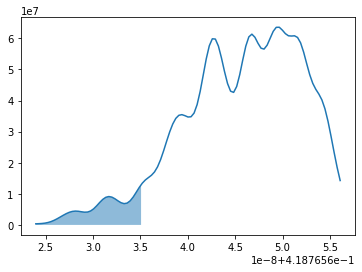

In [142]:
pnl_plot(y_pred[:,1])
#pnl_plot(y_pred[:,0])

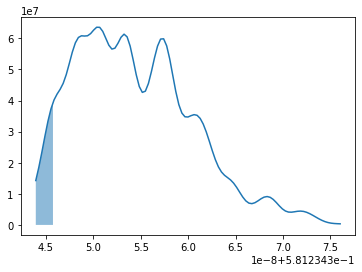

In [143]:
pnl_plot(y_pred[:,0])

In [67]:
#calculate roc and auc
ytrue = ytest.to_numpy().astype(int)
yscore = logisr.decision_function(xtest[fvlist])
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr, tpr, _ = roc_curve(ytrue, yscore)
roc_auc = auc(fpr, tpr)

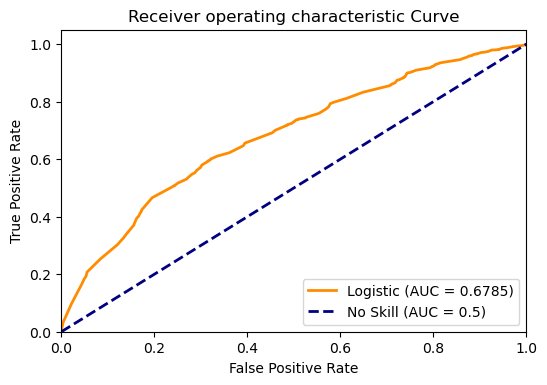

In [68]:
#plot roc curve
plt.figure(figsize=(6,4),dpi=100)
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="Logistic (AUC = %0.4f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--",label="No Skill (AUC = 0.5)" )
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic Curve")
plt.legend(loc="lower right")
plt.show()

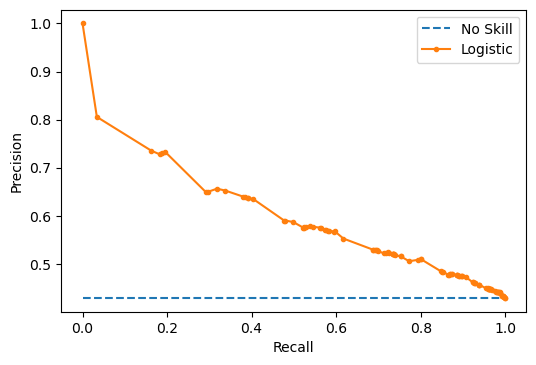

In [23]:
#precision-recall curve
probs = logisr.predict_proba(xtest[fvlist])
probs = probs[:, 1]

precision, recall, thresholds = precision_recall_curve(ytest, probs)
no_skill = len(ytest[ytest['TARGET']==1]) / len(ytest)

plt.figure(figsize=(6,4),dpi=100)
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
plt.plot(recall, precision, marker='.', label='Logistic')
# axis labels
plt.xlabel('Recall')
plt.ylabel('Precision')
# show the legend
plt.legend()
# show the plot
plt.show()

In [85]:
xtrain_ = sm.add_constant(xtrain[fvlist])
lr = sm.Logit(ytrain,xtrain_)
fresult = lr.fit()
fresult.summary()

         Current function value: 5.199967
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                 TARGET   No. Observations:                13972
Model:                          Logit   Df Residuals:                    13965
Method:                           MLE   Df Model:                            6
Date:                Tue, 28 Dec 2021   Pseudo R-squ.:                  -6.648
Time:                        22:19:15   Log-Likelihood:                -72654.
converged:                      False   LL-Null:                       -9499.4
Covariance Type:            nonrobust   LLR p-value:                     1.000
============================================================================================================
                                               coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------------------
const                                      -10.0826   2673.874     -0.004      0.997   -5250.779    5230.614
REGION_RATING_CLIENT_W_CITY_woe           1412.4779    149.952      9.420      0.000    1118.578    1706.378
CNT_DRAWINGS_0_1_year_woe                -6474.4345    543.318    -11.916      0.000   -7539.318   -5409.551
CODE_GENDER_F_woe                          1.22e+06   2.68e+08      0.005      0.996   -5.23e+08    5.26e+08
ORGANIZATION_TYPE_XNA_woe                 6114.7329    243.766     25.084      0.000    5636.959    6592.506
NAME_EDUCATION_TYPE_Higher education_woe  7033.4441    317.668     22.141      0.000    6410.827    7656.061
EXT_SOURCE_3_woe                          1.411e+04    342.049     41.251      0.000    1.34e+04    1.48e+04
============================================================================================================

Possibly complete quasi-separation: A fraction 0.18 of observations can be
perfectly predicted. This might indicate that there is complete
quasi-separation. In this case some parameters will not be identified.
"""